In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict

from tqdm import tqdm
import wfdb

sns.set_style('whitegrid')

C:\Users\andme\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
 class CustomDataset(Dataset):
        def __init__(self, base_path, file_path, sampling_rate=500, max_val=0):
            self.base_path = base_path
            self.sampling_rate = sampling_rate
            self.df = pd.read_csv(self.base_path+file_path)
            self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
            
        def __len__(self):
            return len(self.df)
        
        def __getitem__(self, idx):
            target = self.df.iloc[idx, 3]
            if self.sampling_rate == 100:
                data = wfdb.rdsamp(self.base_path + self.df.iloc[idx, -2])[0]
            else:
                data = wfdb.rdsamp(self.base_path + self.df.iloc[idx, -1])[0]
            return selfe.transform(data.T), torch.tensor(target, dtype=torch.float32)
            
#             return torch.tensor(data.T, dtype=torch.float32)/max_val if max_val>0 else torch.tensor(data.T, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [4]:
# load the custom dataset into tensor form
base_dir = './ptb_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
filename = 'ptbxl_database.csv'

# load the dataset
ecg = CustomDataset(base_path=base_dir, file_path=filename)

In [ ]:
max_val = 0

# dataloader for faster performance
ecg_loader = DataLoader(dataset=ecg, batch_size=128, num_workers=4)
print('converted into dataloader ...')

for idx, (data, label) in tqdm(enumerate(ecg_loader)):
    batch_max_val = torch.max(torch.abs(data))
    if batch_max_val > max_val:
        max_val = batch_max_val
        
        
# use 
        
print(f'Maximum absolute value exist in the dataset is : {max_val}')

converted into dataloader ...


In [ ]:
# set max value equlas 0 for comparision
max_val = 0

# dataloader for faster performance
ecg_loader = DataLoader(dataset=ecg, batch_size=128, num_workers=4)
print('converted into dataloader ...')

for idx, (data, label) in tqdm(enumerate(ecg_loader)):
    batch_max_val = torch.max(torch.abs(data))
    if batch_max_val > max_val:
        max_val = batch_max_val
        
        
# use 
        
print(f'Maximum absolute value exist in the dataset is : {max_val}')

converted into dataloader ...


In [62]:
# normalize the data based on maximum value
ecg = CustomDataset(base_path=base_dir, file_path=filename, max_val=max_val)

# split the data into train, test and validation
ecg_train, ecg_test = torch.utils.data.random_split(ecg, [len(ecg)-3000, 3000])
ecg_train, ecg_validation = torch.utils.data.random_split(ecg_train, [len(ecg_train)-3000, 3000])

# dataloader
ecg_train_loader = DataLoader(dataset=ecg_train, batch_size=32, shuffle=True, num_worker=8)
ecg_validation_loader = DataLoader(dataset=ecg_validation, batch_size=16, shuffle=True, num_worker=8)
ecg_test_loader = DataLoader(dataset=ecg_test, batch_size=16, shuffle=True, num_worker=8)

Min -0.9991442561149597 and Max 0.9998776912689209


In [31]:
# define classifier model

class ECGClassifier(nn.Module):
    def __init__(self, input_ch=12, hidden_ch=32, kernel=5):
        super(ECGClassifier, self).__init__()
        self.kernel = kernel
        self.initial = nn.Sequential(
                        nn.Conv1d(in_channels=input_ch, out_channels=hidden_ch, kernel_size=kernel),
                        nn.BatchNorm1d(hidden_ch),
                        nn.ReLU(),
                        nn.MaxPool1d(kernel_size=2, stride=2)
                        )
        self.main = nn.Sequential(
                    self.cnn_block(hidden_ch, hidden_ch*2),
                    self.cnn_block(hidden_ch*2, hidden_ch*4),
                    self.cnn_block(hidden_ch*4, hidden_ch*8),
                    self.cnn_block(hidden_ch*8, hidden_ch*16)
                    )
        
        self.last = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(hidden_ch*16*8, 512),
                    nn.ReLU(),
                    nn.Linear(512, 64),
                    nn.ReLU(),
                    nn.Linear(64,1),
                    nn.Sigmoid()
                    )

        
    def cnn_block(self, ch_in, ch_out):
        return nn.Sequential(
        nn.Conv1d(in_channels=ch_in, out_channels=ch_out, kernel_size=self.kernel),
                    nn.BatchNorm1d(ch_out),
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size=4, stride=4)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.main(x)
        x = self.last(x)
        return x

In [38]:
model = ECGClassifier()
model = model.to(device)

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
critetion = nn.BCELoss()

In [40]:
def calculate_accuracy(yhat, reals):
    yhat = (yhat>0.5).float()
    correct = yhat.eq(reals.view_as(yhat)).sum()
    acc = correct.float()/len(reals)
    return acc

pred = torch.tensor([[0.6], [0.1], [0.3]])
real = torch.tensor([1, 0, 1])
assert calculate_accuracy(pred, real) == 2/3
print('Successful')

Successful


In [41]:
def train(model, train_loader, optimizer, critetion, device):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for i, (data, target) in enumerate(train_loader):
        # move data to GPU
        data = data.to(device)
        target = target.to(device)
        # make gradient parameter to zero
        optimizer.zero_grad(set_to_none=True)
        # prediction
        yhat = model(data)
        # calculate loss and accuracy
        loss = critetion(yhat, target.view_as(yhat))
        acc = calculate_accuracy(yhat, target)
        # backpropagate loss
        loss.backward()
        # update the gardient parameter based on loss
        optimizer.step()
        # calculate loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss/len(train_loader), epoch_acc/len(train_loader)
    

In [42]:
def validation(model, validation_loader, critetion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():

        for i, (data, target) in enumerate(validation_loader):
            # move data to GPU
            data = data.to(device)
            target = target.to(device)
            # prediction
            yhat = model(data)
            # calculate loss and accuracy
            loss = critetion(yhat, target.view_as(yhat))
            acc = calculate_accuracy(yhat, target)
            # calculate loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss/len(validation_loader), epoch_acc/len(validation_loader)

In [43]:
epochs = 20
history = {'train':defaultdict(list), 'val':defaultdict(list)}

model_path = 'model/ecg_classifier.pt'
basedir = os.path.dirname(model_path)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    open(model_path,'w').close()
    
min_val_loss = float('inf')
verbose = 1
for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = train(model, ecg_train_loader, optimizer, critetion, device)
    val_loss, val_acc = validation(model, ecg_validation_loader, critetion, device)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        
    history['train']['train_loss'].append(train_loss)
    history['train']['train_acc'].append(train_acc)
    history['val']['val_loss'].append(val_loss)
    history['val']['val_acc'].append(val_acc)
    
    if verbose == 1:
        print(f'Epoch : {epoch}, train_loss : {train_loss}, train_acc : {train_acc}, val_loss : {val_loss}, val_acc : {val_acc}')

  5%|████▏                                                                              | 1/20 [00:50<15:53, 50.20s/it]

Epoch : 0, train_loss : 0.5093599905871382, train_acc : 0.7511799024813103, val_loss : 0.4312684903753565, val_acc : 0.8075132978723404


 10%|████████▎                                                                          | 2/20 [01:40<15:08, 50.50s/it]

Epoch : 1, train_loss : 0.4263974463096773, train_acc : 0.8048915882303257, val_loss : 0.4442107515369958, val_acc : 0.8045212765957447


 15%|████████████▍                                                                      | 3/20 [02:31<14:18, 50.48s/it]

Epoch : 2, train_loss : 0.396982278065248, train_acc : 0.82087687217828, val_loss : 0.379068399006699, val_acc : 0.8394281914893617


 20%|████████████████▌                                                                  | 4/20 [03:21<13:28, 50.52s/it]

Epoch : 3, train_loss : 0.3784127281470732, train_acc : 0.8351576105512754, val_loss : 0.3919782991263461, val_acc : 0.8254654255319149


 25%|████████████████████▊                                                              | 5/20 [04:12<12:35, 50.40s/it]

Epoch : 4, train_loss : 0.3645057964656088, train_acc : 0.8391893068949382, val_loss : 0.3687946120316678, val_acc : 0.8304521276595744


 30%|████████████████████████▉                                                          | 6/20 [05:02<11:47, 50.51s/it]

Epoch : 5, train_loss : 0.34719854210964357, train_acc : 0.8492859630873709, val_loss : 0.3616098200387143, val_acc : 0.8430851063829787


 35%|█████████████████████████████                                                      | 7/20 [05:54<11:02, 50.92s/it]

Epoch : 6, train_loss : 0.3354957887620637, train_acc : 0.8548153953118758, val_loss : 0.35963447437562207, val_acc : 0.8444148936170213


 40%|█████████████████████████████████▏                                                 | 8/20 [06:45<10:10, 50.90s/it]

Epoch : 7, train_loss : 0.3201884283110349, train_acc : 0.8622213514164241, val_loss : 0.37684345344438197, val_acc : 0.8361037234042553


 45%|█████████████████████████████████████▎                                             | 9/20 [07:36<09:19, 50.88s/it]

Epoch : 8, train_loss : 0.3058402699051481, train_acc : 0.8682384186320835, val_loss : 0.3827692334084435, val_acc : 0.8420877659574468


 50%|█████████████████████████████████████████                                         | 10/20 [08:27<08:30, 51.07s/it]

Epoch : 9, train_loss : 0.28756541248523826, train_acc : 0.8781108498573303, val_loss : 0.38045458035900237, val_acc : 0.8344414893617021


 55%|█████████████████████████████████████████████                                     | 11/20 [09:20<07:43, 51.45s/it]

Epoch : 10, train_loss : 0.2718449597406869, train_acc : 0.884197579248987, val_loss : 0.3779559026848763, val_acc : 0.8537234042553191


 60%|█████████████████████████████████████████████████▏                                | 12/20 [10:11<06:50, 51.33s/it]

Epoch : 11, train_loss : 0.24888093067389547, train_acc : 0.8991597004611083, val_loss : 0.3619301571173871, val_acc : 0.8507313829787234


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [11:01<05:57, 51.05s/it]

Epoch : 12, train_loss : 0.21795840559884755, train_acc : 0.9131051898002625, val_loss : 0.45075449549612845, val_acc : 0.8241356382978723


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [11:52<05:05, 50.99s/it]

Epoch : 13, train_loss : 0.1904231115460697, train_acc : 0.9226641414141414, val_loss : 0.46479575456853245, val_acc : 0.847406914893617


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [12:43<04:15, 51.03s/it]

Epoch : 14, train_loss : 0.15358186482705855, train_acc : 0.9412813479250127, val_loss : 0.40755343932579174, val_acc : 0.8530585106382979


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [13:34<03:23, 50.96s/it]

Epoch : 15, train_loss : 0.13071330254615257, train_acc : 0.9503156565656565, val_loss : 0.4790906400092818, val_acc : 0.8470744680851063


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [14:25<02:33, 51.14s/it]

Epoch : 16, train_loss : 0.09891962858217984, train_acc : 0.9617358933795582, val_loss : 0.70061528060506, val_acc : 0.8174867021276596


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [15:17<01:42, 51.36s/it]

Epoch : 17, train_loss : 0.08217896483180047, train_acc : 0.9682318878896309, val_loss : 0.6646772734374997, val_acc : 0.8307845744680851


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [16:08<00:51, 51.07s/it]

Epoch : 18, train_loss : 0.06662307898843228, train_acc : 0.9741161616161617, val_loss : 0.6514726270276571, val_acc : 0.8454122340425532


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [16:58<00:00, 50.94s/it]

Epoch : 19, train_loss : 0.06455616842757797, train_acc : 0.9764520202020202, val_loss : 0.6812873025563486, val_acc : 0.8357712765957447


([<matplotlib.axis.XTick at 0x159fed0ca00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

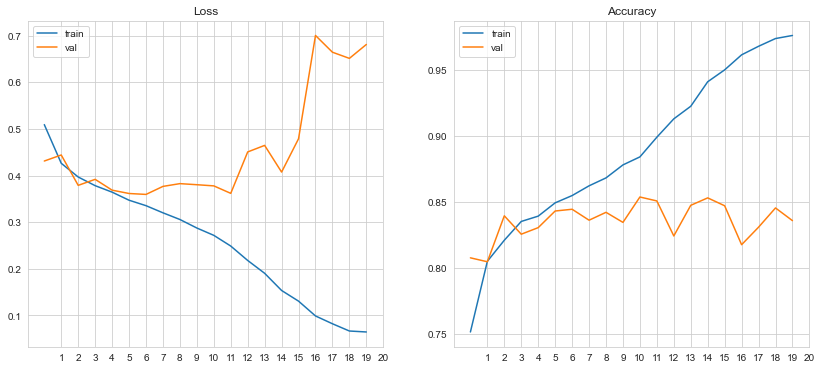

In [55]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(list(range(20)), history['train']['train_loss'], label='train')
plt.plot(list(range(20)), history['val']['val_loss'], label='val')
plt.title('Loss')
plt.legend()
plt.xticks(list(range(1, 21)))
plt.subplot(1, 2, 2)
plt.plot(list(range(20)), history['train']['train_acc'], label='train')
plt.plot(list(range(20)), history['val']['val_acc'], label='val')
plt.title('Accuracy')
plt.legend()
plt.xticks(list(range(1, 21)))

# To be applied
- make history visualization function
- the function will handle the number of metrics automatically 
- it means, function will create the number of graphs based on number of metrics

In [44]:
# test the model
test_loss, test_acc = validation(model, ecg_test_loader, critetion, device)

In [46]:
print(f'Test loss : {test_loss}, Test Accuracy : {test_acc}')

Test loss : 0.6867115947831561, Test Accuracy : 0.8367686170212766


In [47]:
# load the save model
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, test_acc = validation(model, ecg_test_loader, critetion, device)
print(f'Test loss : {test_loss}, Test Accuracy : {test_acc}')

Test loss : 0.34730033227737916, Test Accuracy : 0.8487367021276596


# Observation
- The model seems to be overfitted
- Include l2 regularization
- Play around with betas of adam optimizer
- Play around with learning rate of adam